This page was created from a Jupyter notebook. The original notebook can be found [here](https://github.com/klane/databall/blob/master/notebooks/model-performance.ipynb). It compares model performance using various algorithms. First we must import the necessary installed modules.

In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from databall.database import Database
from databall.plotting import format_538, plot_confusion_matrix
from databall.profit import profit
from databall.simulate import simulate

In [3]:
plt.style.use('fivethirtyeight')

# Data

In [47]:
stats = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK']
stats = ['TEAM_' + s for s in stats] + ['POSSESSIONS']
stats += [s + '_AWAY' for s in stats] + ['HOME_SPREAD']
var_predict = 'HOME_SPREAD_WL'

In [48]:
database = Database('../data/nba.db')
games = database.betting_stats(window=10)
games = games.loc[games.SEASON>=2006, stats + ['SEASON', 'GAME_DATE', var_predict]].dropna()

# Logistic Regression

In [38]:
model = LogisticRegression(C=0.0001943920615336294, penalty='l2',
                           fit_intercept=True, intercept_scaling=134496.71823111628)
output_log = simulate(model, games, 2016, stats, var_predict)
days_log, cumper_log, cumprofit_log = profit(output_log, var_predict='HOME_SPREAD_WL', bet_amount=100)

The function defined below displays a nicely formatted [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix). It is a slightly modified version of the function found [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).

Logistic regression correctly predicts about 70% of games. The confusion matrix shows that the model really shines in predicting home wins, where it correctly predicted 81.5% of games in which the home team won. However, it struggles to predict home losses, where it barely manages to get half of the games right. A [classification report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) is printed below the confusion matrix that displays metrics such as precision and recall.

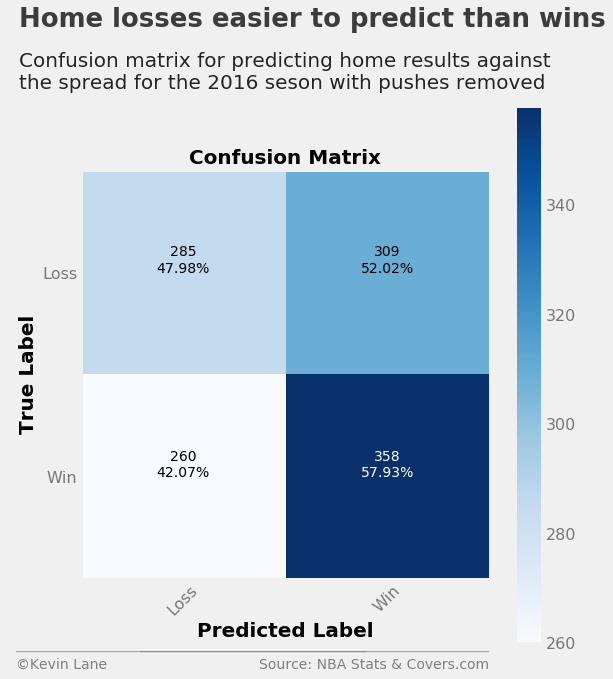

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.523     0.480     0.500       594
        Win      0.537     0.579     0.557       618

avg / total      0.530     0.531     0.529      1212

Correctly predicted 53.05% of games


In [39]:
cm = confusion_matrix(output_log.HOME_SPREAD_WL, output_log.HOME_SPREAD_WL_PRED)

fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, ['Loss', 'Win'], fig=fig)

title = 'Home losses easier to predict than wins'
subtitle = '''Confusion matrix for predicting home results against
the spread for the 2016 seson with pushes removed'''
format_538(fig, 'NBA Stats & Covers.com', title=title, subtitle=subtitle, ax=fig.axes,
           xoff=(-0.18, 1.02), yoff=(-0.17, -0.22), toff=(-.15, 1.35), soff=(-0.15, 1.2),
           n=50, bottomtick=np.nan)
plt.show()

print('_' * 52)
print(classification_report(output_log.HOME_SPREAD_WL, output_log.HOME_SPREAD_WL_PRED,
                            target_names=['Loss', 'Win'], digits=3))
print('Correctly predicted {:.2f}% of games'
      .format(accuracy_score(output_log.HOME_SPREAD_WL, output_log.HOME_SPREAD_WL_PRED) * 100))

# Support Vector Machine

In [40]:
model = LinearSVC(C=3.2563857398383885e-06, loss='squared_hinge',
                           fit_intercept=True, intercept_scaling=242.79319791592195)
output_svm = simulate(model, games, 2016, stats, var_predict)
days_svm, cumper_svm, cumprofit_svm = profit(output_svm, var_predict='HOME_SPREAD_WL', bet_amount=100)

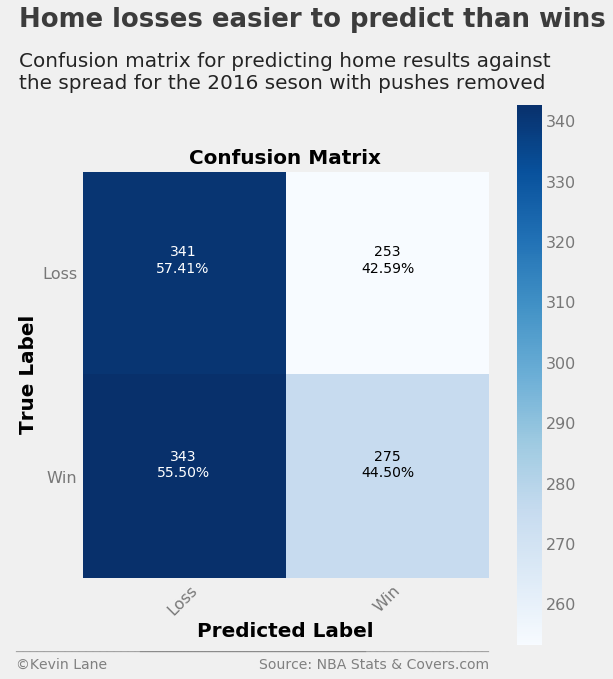

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.499     0.574     0.534       594
        Win      0.521     0.445     0.480       618

avg / total      0.510     0.508     0.506      1212

Correctly predicted 50.83% of games


In [41]:
cm = confusion_matrix(output_svm.HOME_SPREAD_WL, output_svm.HOME_SPREAD_WL_PRED)

fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, ['Loss', 'Win'], fig=fig)

title = 'Home losses easier to predict than wins'
subtitle = '''Confusion matrix for predicting home results against
the spread for the 2016 seson with pushes removed'''
format_538(fig, 'NBA Stats & Covers.com', title=title, subtitle=subtitle, ax=fig.axes,
           xoff=(-0.18, 1.02), yoff=(-0.17, -0.22), toff=(-.15, 1.35), soff=(-0.15, 1.2),
           n=50, bottomtick=np.nan)
plt.show()

print('_' * 52)
print(classification_report(output_svm.HOME_SPREAD_WL, output_svm.HOME_SPREAD_WL_PRED,
                            target_names=['Loss', 'Win'], digits=3))
print('Correctly predicted {:.2f}% of games'
      .format(accuracy_score(output_svm.HOME_SPREAD_WL, output_svm.HOME_SPREAD_WL_PRED) * 100))

# Random Forest

In [42]:
model = RandomForestClassifier(n_estimators=34, criterion='entropy', class_weight='balanced',
                               bootstrap=True, random_state=8)
output_rf = simulate(model, games, 2016, stats, var_predict)
days_rf, cumper_rf, cumprofit_rf = profit(output_rf, var_predict='HOME_SPREAD_WL', bet_amount=100)

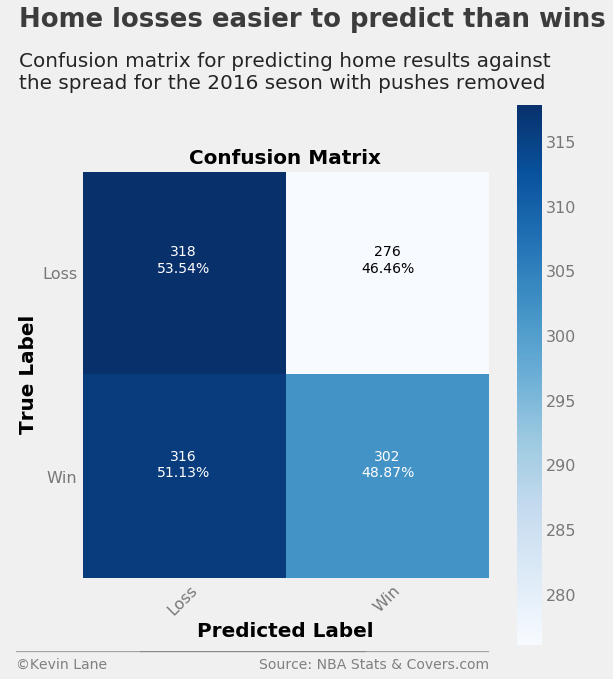

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.502     0.535     0.518       594
        Win      0.522     0.489     0.505       618

avg / total      0.512     0.512     0.511      1212

Correctly predicted 51.16% of games


In [43]:
cm = confusion_matrix(output_rf.HOME_SPREAD_WL, output_rf.HOME_SPREAD_WL_PRED)

fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, ['Loss', 'Win'], fig=fig)

title = 'Home losses easier to predict than wins'
subtitle = '''Confusion matrix for predicting home results against
the spread for the 2016 seson with pushes removed'''
format_538(fig, 'NBA Stats & Covers.com', title=title, subtitle=subtitle, ax=fig.axes,
           xoff=(-0.18, 1.02), yoff=(-0.17, -0.22), toff=(-.15, 1.35), soff=(-0.15, 1.2),
           n=50, bottomtick=np.nan)
plt.show()

print('_' * 52)
print(classification_report(output_rf.HOME_SPREAD_WL, output_rf.HOME_SPREAD_WL_PRED,
                            target_names=['Loss', 'Win'], digits=3))
print('Correctly predicted {:.2f}% of games'
      .format(accuracy_score(output_rf.HOME_SPREAD_WL, output_rf.HOME_SPREAD_WL_PRED) * 100))

# Neural Network

In [44]:
model = MLPClassifier(alpha=5.700733605522687e-06, hidden_layer_sizes=49,
                      solver='lbfgs', activation='tanh')
output_mlp = simulate(model, games, 2016, stats, var_predict)
days_mlp, cumper_mlp, cumprofit_mlp = profit(output_mlp, var_predict='HOME_SPREAD_WL', bet_amount=100)

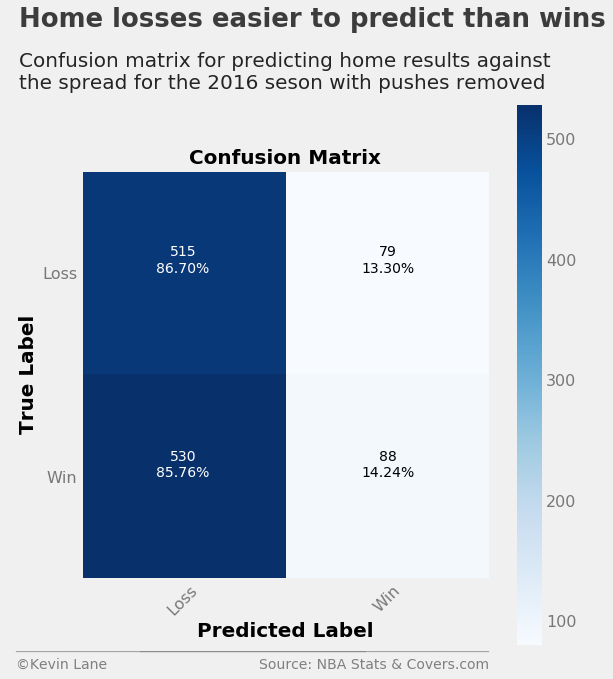

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.493     0.867     0.628       594
        Win      0.527     0.142     0.224       618

avg / total      0.510     0.498     0.422      1212

Correctly predicted 49.75% of games


In [45]:
cm = confusion_matrix(output_mlp.HOME_SPREAD_WL, output_mlp.HOME_SPREAD_WL_PRED)

fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, ['Loss', 'Win'], fig=fig)

title = 'Home losses easier to predict than wins'
subtitle = '''Confusion matrix for predicting home results against
the spread for the 2016 seson with pushes removed'''
format_538(fig, 'NBA Stats & Covers.com', title=title, subtitle=subtitle, ax=fig.axes,
           xoff=(-0.18, 1.02), yoff=(-0.17, -0.22), toff=(-.15, 1.35), soff=(-0.15, 1.2),
           n=50, bottomtick=np.nan)
plt.show()

print('_' * 52)
print(classification_report(output_mlp.HOME_SPREAD_WL, output_mlp.HOME_SPREAD_WL_PRED,
                            target_names=['Loss', 'Win'], digits=3))
print('Correctly predicted {:.2f}% of games'
      .format(accuracy_score(output_mlp.HOME_SPREAD_WL, output_mlp.HOME_SPREAD_WL_PRED) * 100))

# Model Retraining

# Model Comparison

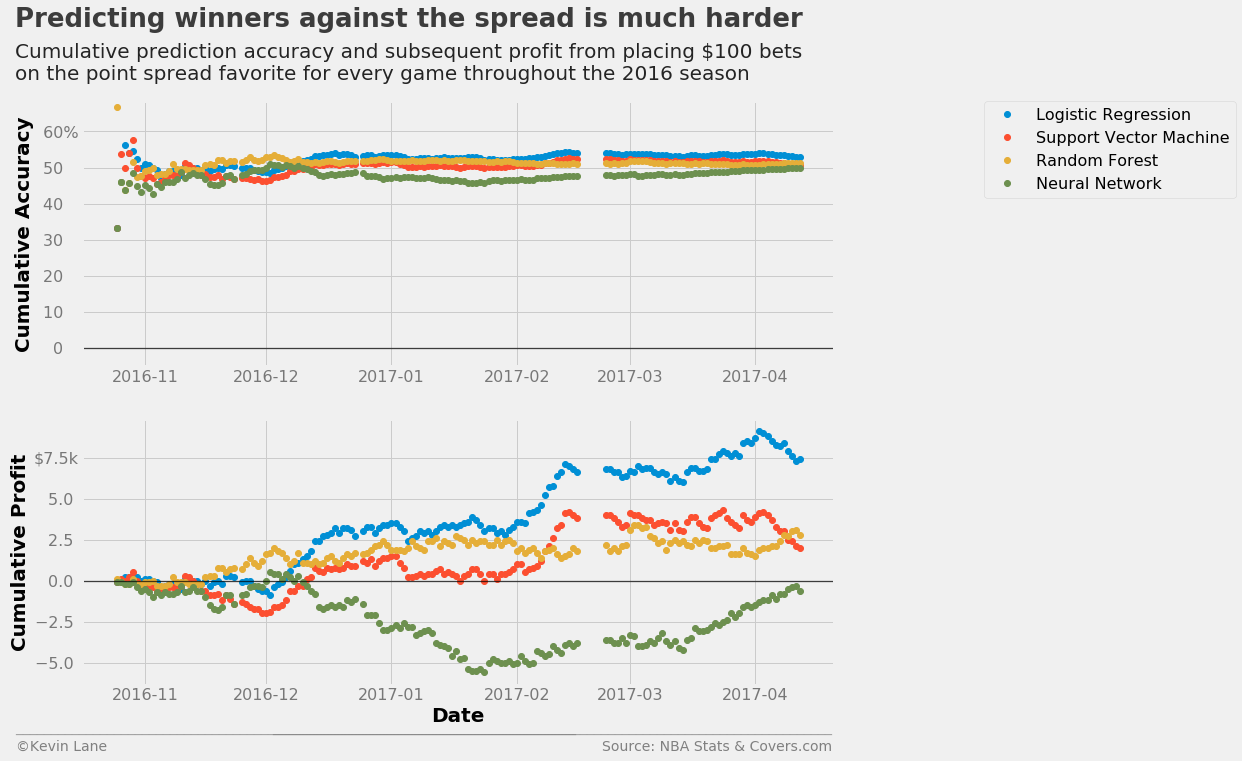

In [46]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(211)
ax1.plot_date(days_log, cumper_log*100, label='Logistic Regression')
ax1.plot_date(days_svm, cumper_svm*100, label='Support Vector Machine')
ax1.plot_date(days_rf, cumper_rf*100, label='Random Forest')
ax1.plot_date(days_mlp, cumper_mlp*100, label='Neural Network')
ax1.set_ylabel('Cumulative Accuracy')
ax1.set_ylim(-5)
ax1.legend(fontsize=16, bbox_to_anchor=(1.2, 1), borderaxespad=0)

ax2 = plt.subplot(212)
ax2.plot_date(days_log, cumprofit_log/1000)
ax2.plot_date(days_svm, cumprofit_svm/1000)
ax2.plot_date(days_rf, cumprofit_rf/1000)
ax2.plot_date(days_mlp, cumprofit_mlp/1000)
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Profit')
# ax2.set_ylim(-15, 42)

title = 'Predicting winners against the spread is much harder'
subtitle = '''Cumulative prediction accuracy and subsequent profit from placing $100 bets
on the point spread favorite for every game throughout the 2016 season'''
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.1, 1.01), yoff=(-1.38, -1.45), toff=(-.09, 1.28), soff=(-0.09, 1.08), 
           prefix = (' ', '$'), suffix=('%', 'k'), suffix_offset=(3, 1), n=80)
plt.show()

In [49]:
model = LogisticRegression()
output_log = simulate(model, games, 2016, stats, var_predict)
days_log, cumper_log, cumprofit_log = profit(output_log, var_predict='HOME_SPREAD_WL', bet_amount=100)

model = LinearSVC()
output_svm = simulate(model, games, 2016, stats, var_predict)
days_svm, cumper_svm, cumprofit_svm = profit(output_svm, var_predict='HOME_SPREAD_WL', bet_amount=100)

model = RandomForestClassifier()
output_rf = simulate(model, games, 2016, stats, var_predict)
days_rf, cumper_rf, cumprofit_rf = profit(output_rf, var_predict='HOME_SPREAD_WL', bet_amount=100)

model = MLPClassifier()
output_mlp = simulate(model, games, 2016, stats, var_predict)
days_mlp, cumper_mlp, cumprofit_mlp = profit(output_mlp, var_predict='HOME_SPREAD_WL', bet_amount=100)

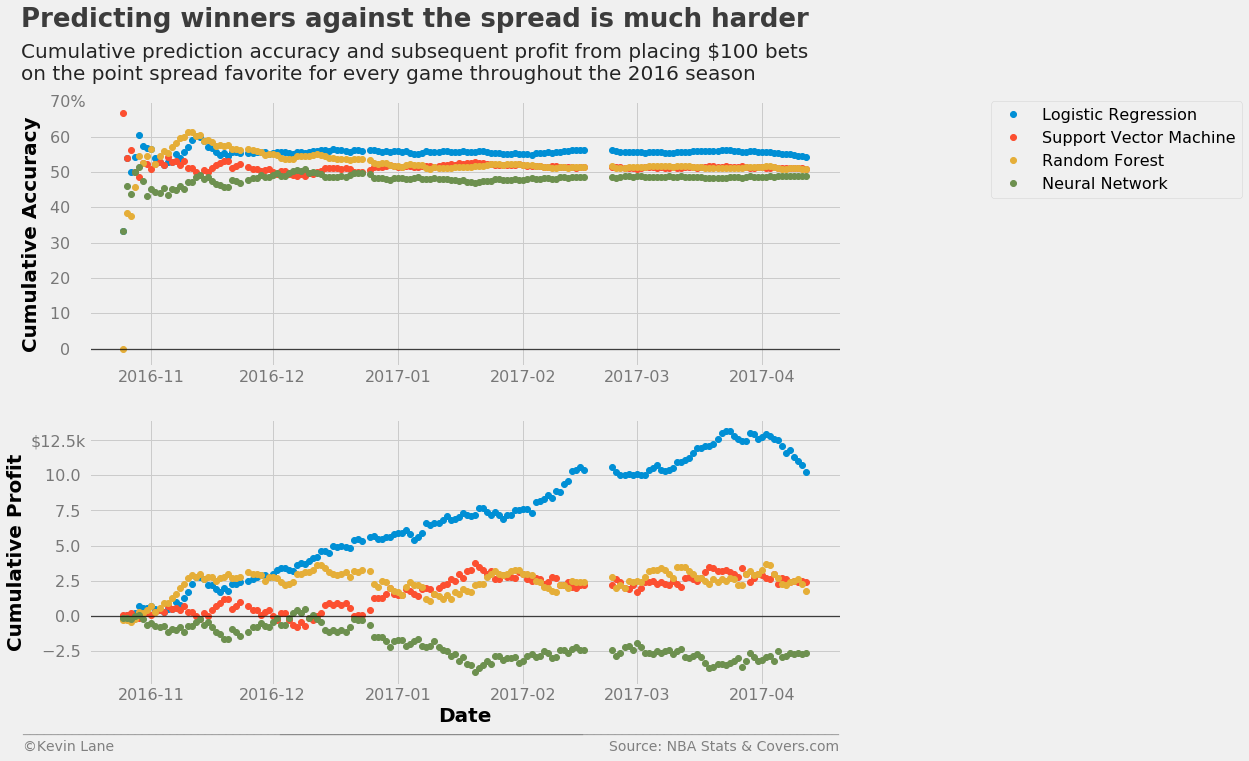

In [50]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(211)
ax1.plot_date(days_log, cumper_log*100, label='Logistic Regression')
ax1.plot_date(days_svm, cumper_svm*100, label='Support Vector Machine')
ax1.plot_date(days_rf, cumper_rf*100, label='Random Forest')
ax1.plot_date(days_mlp, cumper_mlp*100, label='Neural Network')
ax1.set_ylabel('Cumulative Accuracy')
ax1.set_ylim(-5)
ax1.legend(fontsize=16, bbox_to_anchor=(1.2, 1), borderaxespad=0)

ax2 = plt.subplot(212)
ax2.plot_date(days_log, cumprofit_log/1000)
ax2.plot_date(days_svm, cumprofit_svm/1000)
ax2.plot_date(days_rf, cumprofit_rf/1000)
ax2.plot_date(days_mlp, cumprofit_mlp/1000)
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Profit')
# ax2.set_ylim(-15, 42)

title = 'Predicting winners against the spread is much harder'
subtitle = '''Cumulative prediction accuracy and subsequent profit from placing $100 bets
on the point spread favorite for every game throughout the 2016 season'''
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.1, 1.01), yoff=(-1.38, -1.45), toff=(-.09, 1.28), soff=(-0.09, 1.08), 
           prefix = (' ', '$'), suffix=('%', 'k'), suffix_offset=(3, 1), n=80)
plt.show()